In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.interpolate import make_interp_spline
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsOneClassifier

#### We can fetch the dataset using sklearnm

In [2]:
# Now, fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version= 1)

#### Dataset already have structure including X attributes, y target, DESCR description of dataset

In [3]:
X, y = mnist['data'], mnist['target']


In [4]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [6]:
y.shape

(70000,)

In [7]:
X.shape

(70000, 784)

#### There are 70 000 images and each image with 784 features

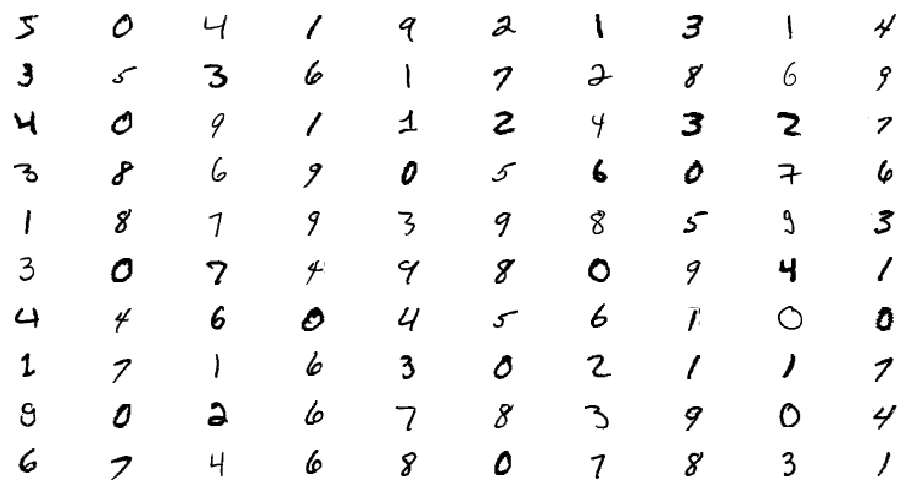

In [8]:
# a few 100 digit from MNIST dataset
fig, axes = plt.subplots(10, 10, figsize= (10, 5))
store = []

for cnt, path in enumerate(X.iloc[:100].values):
    image = path
    image_reshaped = image.reshape(28, 28)
    store.append(image_reshaped)
    
    ax = axes[cnt // 10, cnt % 10]
    ax.imshow(image_reshaped, cmap= mpl.cm.binary, interpolation= 'nearest')
    ax.axis('off')

plt.tight_layout() 
plt.show()   

In [69]:
# each image with 28 x 28 pixes. we need to reshape any instance's feature vector
some_digit = X.iloc[1].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

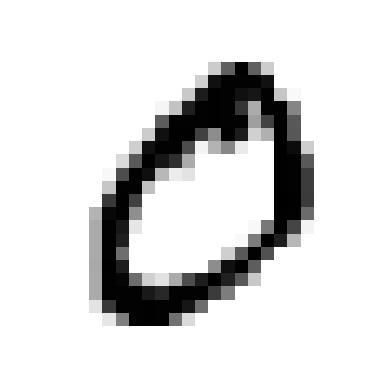

In [60]:
# display image
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation= 'nearest')
plt.axis('off')

plt.show()

#### Digit look like 0, we can use target y to check if its realy 0

In [62]:
print(y[1])

0


#### Indeed it is 0

#####

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


In [13]:
X.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [14]:
# NaN 
X.isna().mean()

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Length: 784, dtype: float64

In [15]:
y.isna().sum()

np.int64(0)

In [16]:
X.isna().sum().sum()

np.int64(0)

#### We can now create a train and test sets

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [18]:
y_train.shape

(60000,)

In [19]:
X_train.shape

(60000, 784)

#### We can use one_vs_one_Classifier strategy since we work with mutliclass classification

In [80]:
## choose a model
sgd_model_with_ovo = OneVsOneClassifier(SGDClassifier(random_state= 42))

try:
    sgd_model_with_ovo.fit(X_train, y_train)
    print('The model trained successfully')

except Exception as e:
    print(f'The model failed to train: {e}')    

The model trained successfully


#### The model is doing well but not perfect, is failing to correctly predict all the digits. We can check its perfomance by measuring the score and accuracy

In [83]:
## predictions
predictions_with_ovo = sgd_model_with_ovo.predict(X_test)

## scores
accuracy_of_ovo = accuracy_score(y_test, predictions_with_ovo)

print(f'The perfomance:\n')
print(f'accuracy = {accuracy_of_ovo}')

The perfomance:

accuracy = 0.9245


In [95]:
# perfomamce array
''' y_scores_with_ovo = cross_val_score(sgd_model_with_ovo, X_train, y_train, cv= 3, scoring= 'accuracy') '''

" y_scores_with_ovo = cross_val_score(sgd_model_with_ovo, X_train, y_train, cv= 3, scoring= 'accuracy') "

In [96]:
# predictions
y_pred_with_ovo = cross_val_predict(sgd_model_with_ovo, X_train, y_train, cv= 3)

#### The model perfomed well, even though it needs to be improved

#### We can explore other algorithms for better perfomance

In [24]:
""" skfolds = StratifiedKFold(n_splits= 3, shuffle= True)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_model)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_test[test_index]
    y_test_folds = y_test[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_corrected = sum(y_pred == y_test_folds)
    print(n_corrected / len(y_pred)) """

' skfolds = StratifiedKFold(n_splits= 3, shuffle= True)\n\nfor train_index, test_index in skfolds.split(X_train, y_train):\n    clone_clf = clone(sgd_model)\n    X_train_folds = X_train[train_index]\n    y_train_folds = y_train[train_index]\n    X_test_folds = X_test[test_index]\n    y_test_folds = y_test[test_index]\n\n    clone_clf.fit(X_train_folds, y_train_folds)\n    y_pred = clone_clf.predict(X_test_folds)\n    n_corrected = sum(y_pred == y_test_folds)\n    print(n_corrected / len(y_pred)) '

#### Confusion matrix for better model evaluation

In [98]:
conf_matrix = confusion_matrix(y_train, y_pred_with_ovo)

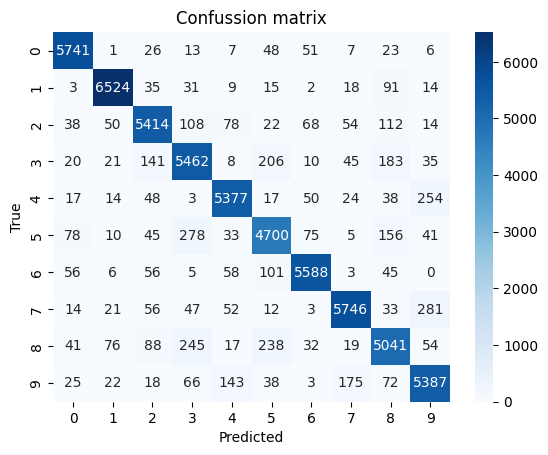

In [99]:
# plot confusion matrix
sns.heatmap(conf_matrix, cmap= 'Blues', annot= True, fmt= 'd', cbar= True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confussion matrix')

plt.show()

#### We can go on to plot ROC curve which illustrates the perfomance of the classifier model at variying thresholds

##### It plots the True positive rates(TPr) against False positive rates(FPr)

In [ ]:
# we are dealing with multiclass classification

In [107]:
# plot roc
'''fpr, tpr, thresholds = roc_curve(y_train, y_pred_with_ovo)

def plot_roc(fpr, tpr, label= None):
    plt.plot(fpr, tpr, linewidth= 2, label= label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC curve')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')

plot_roc(fpr, tpr)

plt.show()    '''

"fpr, tpr, thresholds = roc_curve(y_train, y_pred_with_ovo)\n\ndef plot_roc(fpr, tpr, label= None):\n    plt.plot(fpr, tpr, linewidth= 2, label= label)\n    plt.plot([0, 1], [0, 1], 'k--')\n    plt.title('ROC curve')\n    plt.ylabel('True positive rate')\n    plt.xlabel('False positive rate')\n\nplot_roc(fpr, tpr)\n\nplt.show()    "

#####

#### ROC curve for one class vs all to make binary classification : we need to use one class (eg, digid - 0) for evaluation

In [ ]:
# single selected digid - 0
y_train_0 = (y_train == '0')
y_test_0 = (y_test == '0')

In [104]:
# train the model with only one digid selected 
sgd_model_0 = SGDClassifier(random_state= 42)

try:
    sgd_model_0.fit(X_train, y_train_0)
    print('The model trained successfully')

except Exception as e:
    print(f'The model failed to train: {e}')

The model trained successfully


In [105]:
# perfomance
accuracy_0 = cross_val_score(sgd_model_0, X_train, y_train_0, cv= 3, scoring= 'accuracy')

print(f'The perfomance: \n{accuracy_0}')

The perfomance: 
[0.9854 0.9847 0.9865]


In [109]:
# predictions
y_scores_0 = cross_val_predict(sgd_model_0, X_train, y_train_0, cv= 3)

#### ROC curve for single class

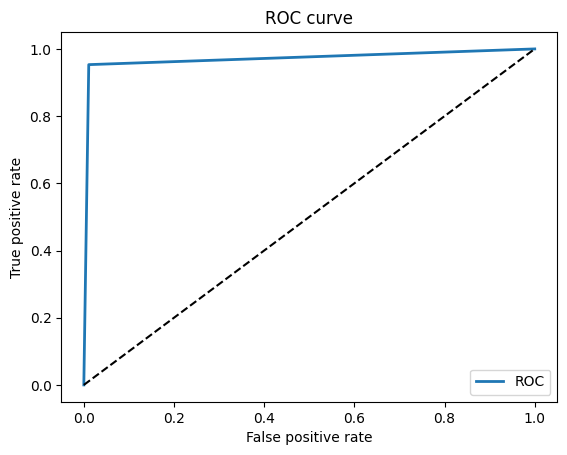

In [112]:
# plot roc
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores_0)

def plot_roc(fpr, tpr, label= None):
    plt.plot(fpr, tpr, linewidth= 2, label= 'ROC')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC curve')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')

plot_roc(fpr, tpr)
plt.legend()
plt.show()    

#### Evaluation continue

In [115]:
# scores
some_digit_score = sgd_model_with_ovo.decision_function([some_digit])
highest_score = np.argmax(some_digit_score)

print(f'The perfomance score:\n{highest_score}')

The perfomance score:
0


C:\Users\topol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


#### We can save our Model 

In [ ]:
# save model